# Control


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
sns.set_theme(style="whitegrid")


In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks

1. Create dataset without control tracks
2. Launch peak calling

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True omnipeak=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  omnipeak=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=False omnipeak=True sicer=True --rerun-trigger mtime;
```


In [4]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_NO_CONTROL_PATH = os.path.expanduser('~/data/2023_Immune_no_control')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [5]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'Omnipeak']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak']

In [6]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    if not os.path.exists(path):
        return df
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [7]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    if len(df_sicer) == 0:
        df_sicer = load_peaks(os.path.join(path, 'sicer'), 'E100.scoreisland', modifications, cells, replicates) 
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_omnipeak = load_peaks(os.path.join(path, 'omnipeak'), '.peak', modifications, cells, replicates)
    df_omnipeak['tool'] = 'Omnipeak'
    print('Omnipeak', len(df_omnipeak))

    df_homer = load_peaks(os.path.join(path, 'homer'), '.peaks', modifications, cells, replicates)
    df_homer['tool'] = 'HOMER'
    print('HOMER', len(df_homer))

    df_hotspot = load_peaks(os.path.join(path, 'hotspot'), '.peak', modifications, cells, replicates)
    df_hotspot['tool'] = 'Hotspot'
    print('Hotspot', len(df_hotspot))

    df_lanceotron = load_peaks(os.path.join(path, 'lanceotron'), '.bed', modifications, cells, replicates)
    df_lanceotron['tool'] = 'LanceOtron'
    print('LanceOtron', len(df_lanceotron))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_omnipeak, df_homer, df_hotspot, df_lanceotron]).reset_index(drop=True)

In [8]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks['control'] = True

df_encode_no_control_peaks = load_peaks_path(GSE26320_NO_CONTROL_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_no_control_peaks['dataset'] = 'ENCODE'
df_encode_no_control_peaks['control'] = False

df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks['control'] = True

df_immune_no_control_peaks = load_peaks_path(IMMUNE_NO_CONTROL_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_no_control_peaks['dataset'] = 'Roadmap'
df_immune_no_control_peaks['control'] = False

df_peaks_full = pd.concat([df_encode_peaks, df_encode_no_control_peaks, 
                      df_immune_peaks, df_immune_no_control_peaks]).reset_index(drop=True)
df_peaks_full.sample(3)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/358 [00:00<?, ?it/s]

Omnipeak 85


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 85


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 85


  0%|          | 0/170 [00:00<?, ?it/s]

LanceOtron 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/341 [00:00<?, ?it/s]

Omnipeak 85


  0%|          | 0/85 [00:00<?, ?it/s]

HOMER 85


  0%|          | 0/85 [00:00<?, ?it/s]

Hotspot 85


  0%|          | 0/170 [00:00<?, ?it/s]

LanceOtron 85


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/194 [00:00<?, ?it/s]

Omnipeak 46


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 46


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 46


  0%|          | 0/92 [00:00<?, ?it/s]

LanceOtron 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/184 [00:00<?, ?it/s]

Omnipeak 46


  0%|          | 0/46 [00:00<?, ?it/s]

HOMER 46


  0%|          | 0/46 [00:00<?, ?it/s]

Hotspot 46


  0%|          | 0/92 [00:00<?, ?it/s]

LanceOtron 46


,file,modification,cell,replicate,peaks,tool,dataset,control
91,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K36me3,HSMM,rep1,1230,MACS2 broad,ENCODE,True
1027,/home/jetbrains/data/2023_GSE26320_no_control/...,H3K27ac,HepG2,rep2,104178,Hotspot,ENCODE,False
1822,/home/jetbrains/data/2023_Immune_no_control/la...,H3K4me3,CD34,,60029,LanceOtron,Roadmap,False


ENCODE


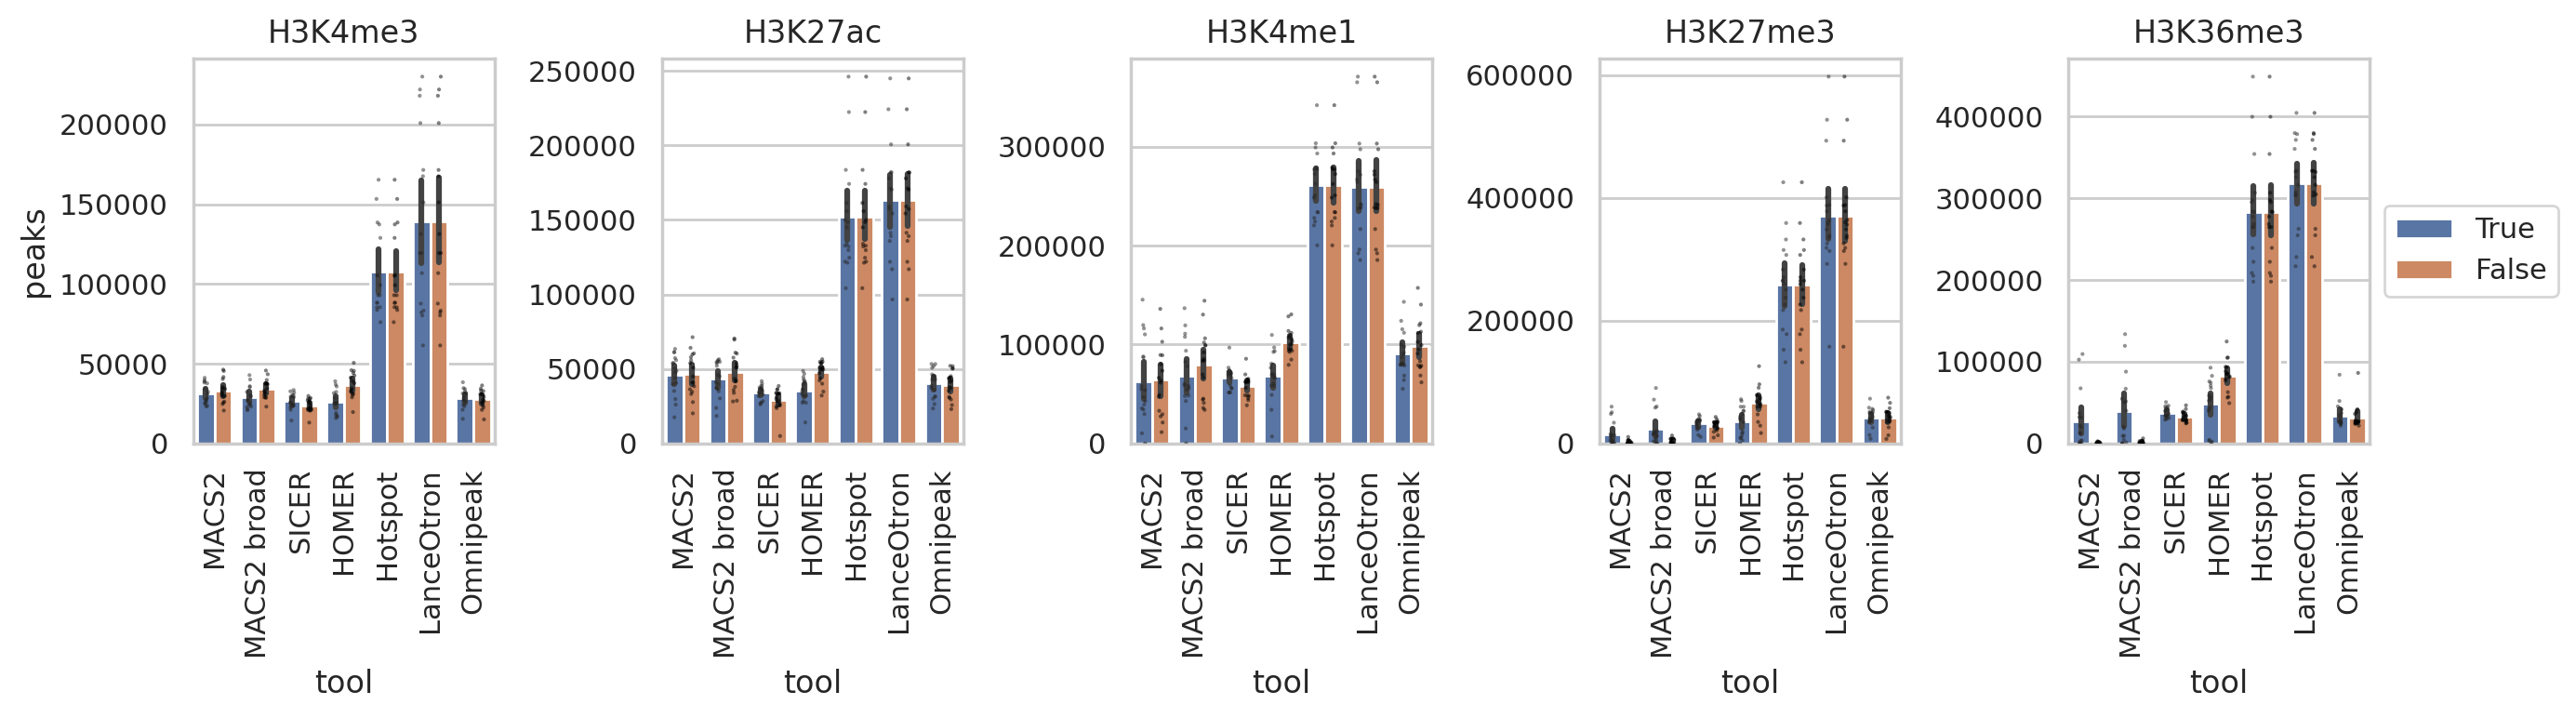

Roadmap


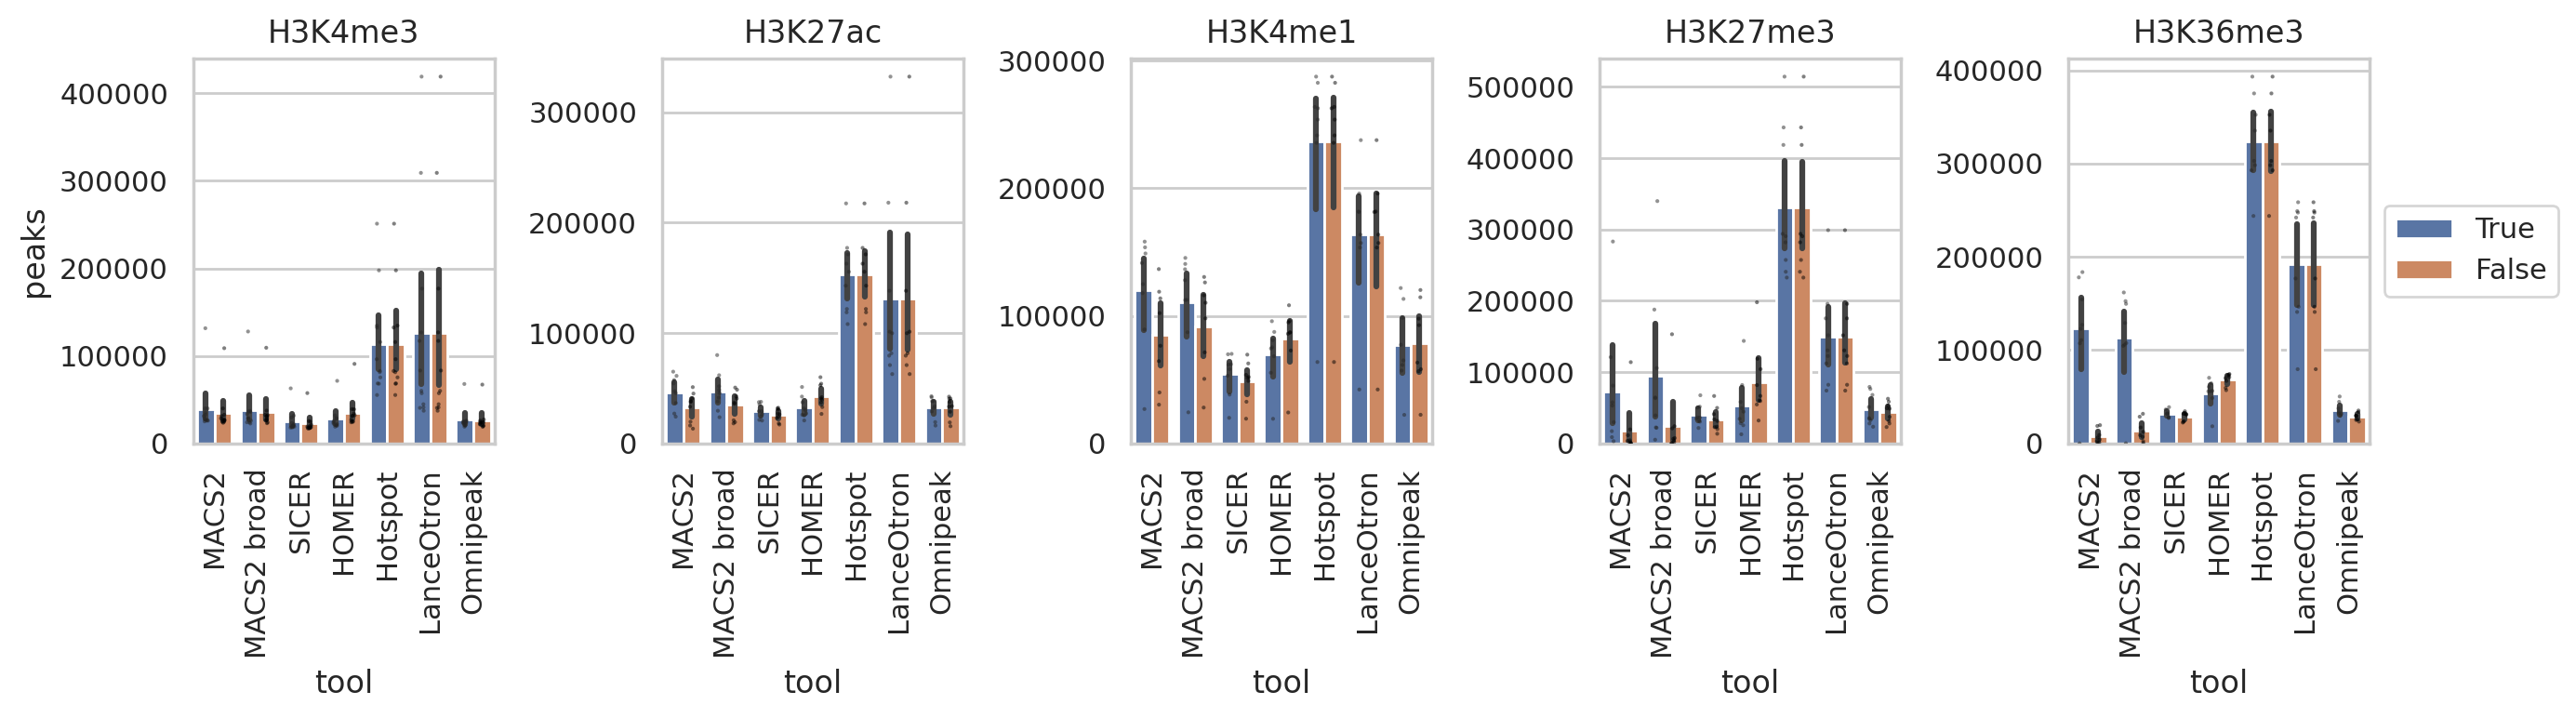

In [9]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks_full[(df_peaks_full['dataset'] == ds) & 
                                  (df_peaks_full['modification'] == m)],
                    x='tool', y='peaks', hue='control',
                    # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                    order=TOOLS,
                    hue_order=[True, False],
                    ax=ax,)
        sns.stripplot(data=df_peaks_full[(df_peaks_full['dataset'] == ds) &
                                    (df_peaks_full['modification'] == m)],
                      x='tool', y='peaks', hue='control',
                      dodge=True, size=1.5, color="black", alpha=0.5, palette='dark:black',
                      order=TOOLS, legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

In [10]:
df_peaks_full[(df_peaks_full['tool'] == 'Omnipeak') & (df_peaks_full['modification'] == 'H3K27me3') & (df_peaks_full['peaks'] > 100_000)]

,file,modification,cell,replicate,peaks,tool,dataset,control


In [11]:
# Remove outliers, see figures.ipynb
OUTLIERS = [
    ('H3K4me3', 'NK', ''),
    ('H3K27ac', 'CD34', 'rep2'),
    ('H3K4me1', 'NK', ''),
    ('H3K27me3', 'BCell', ''),
    ('H3K27me3', 'TCell', ''),
    ('H3K27me3', 'NK', ''),
]
df_peaks = df_peaks_full.loc[[(m, c, r) not in OUTLIERS
                              for _, (m, c, r) in df_peaks_full[['modification', 'cell', 'replicate']].iterrows()]].copy()
df_peaks.sample(3)

,file,modification,cell,replicate,peaks,tool,dataset,control
583,/home/jetbrains/data/2023_GSE26320/lanceotron/...,H3K4me3,GM12878,rep2,200891,LanceOtron,ENCODE,True
201,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,Huvec,rep2,70741,SICER,ENCODE,True
1634,/home/jetbrains/data/2023_Immune_no_control/si...,H3K27ac,Monocyte,,31726,SICER,Roadmap,False


ENCODE


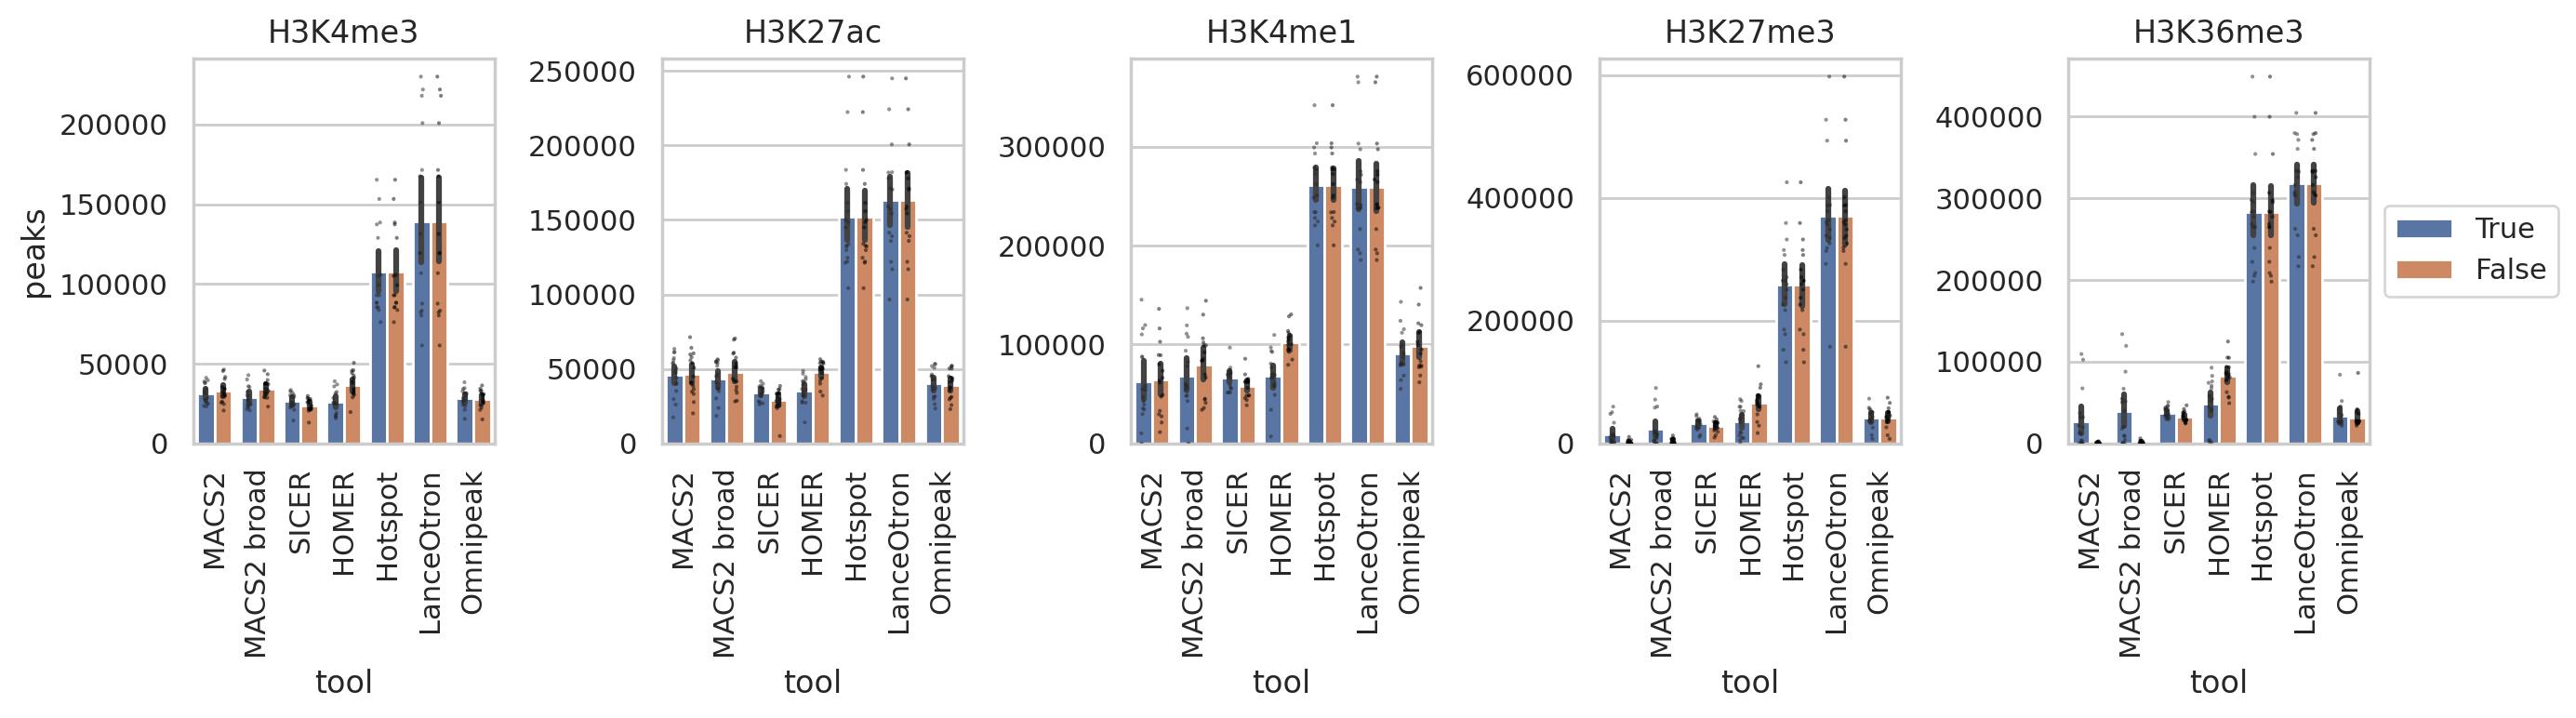

Roadmap


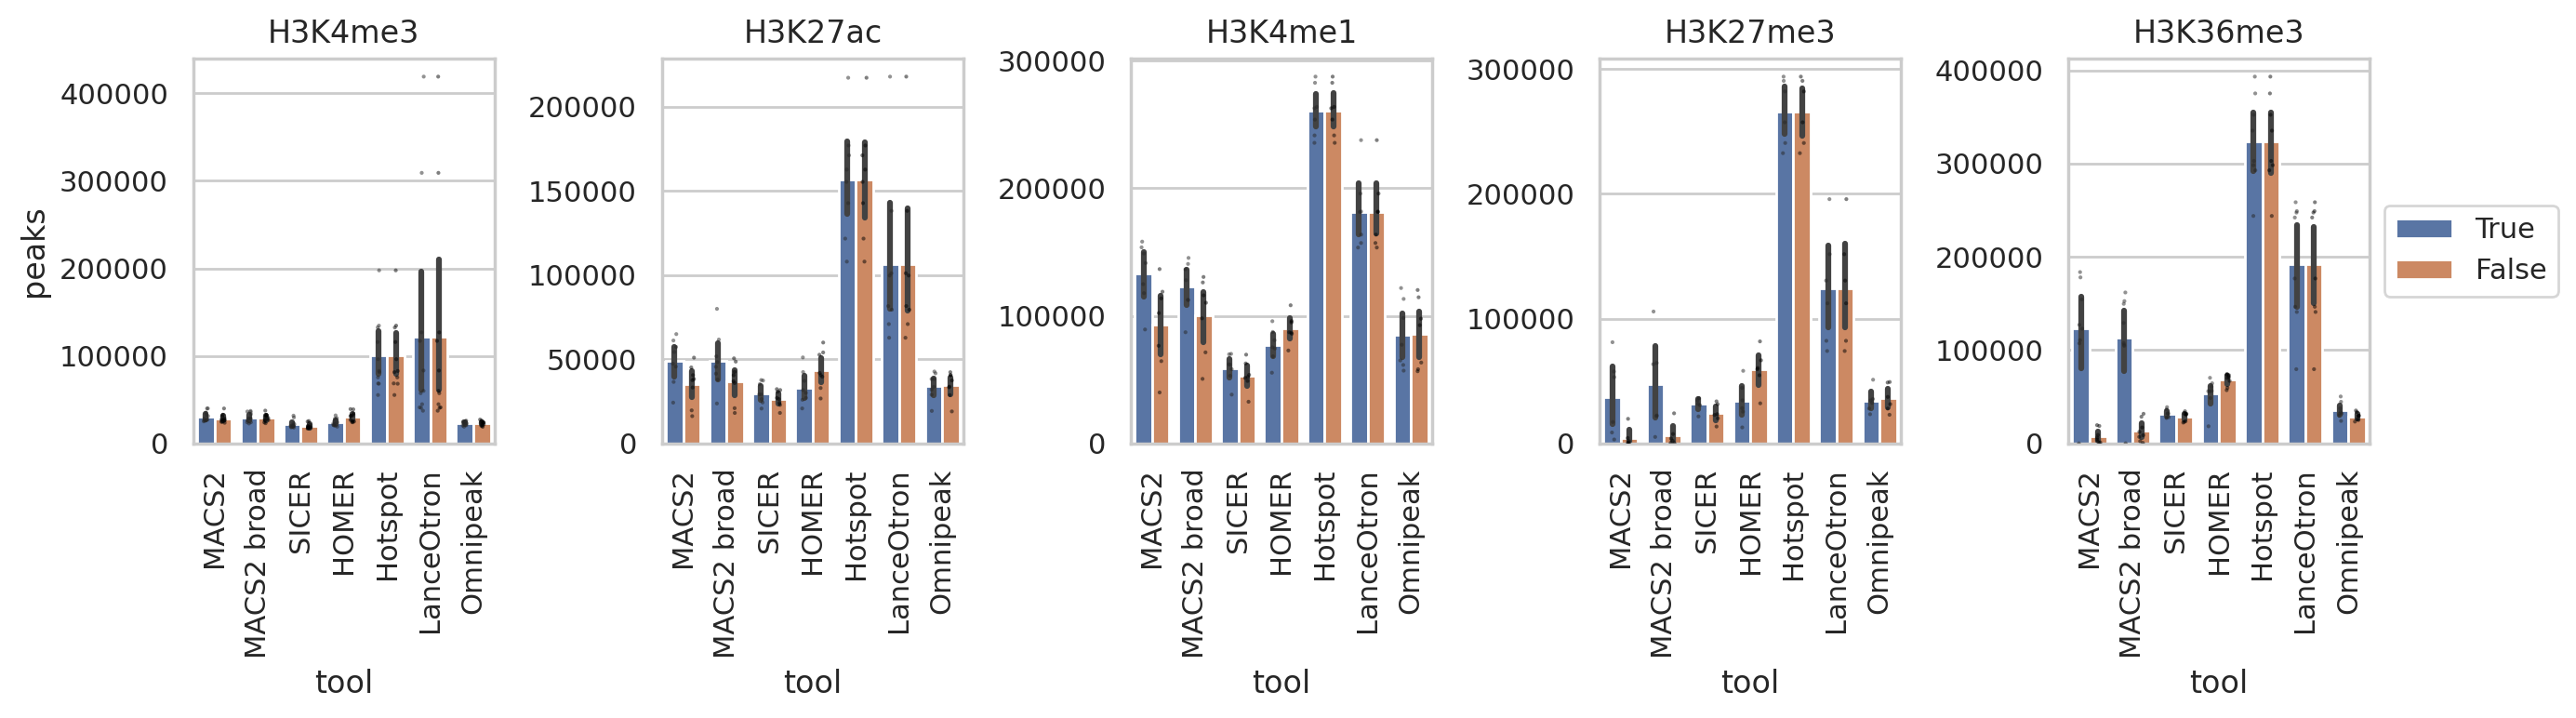

In [12]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(14, 4))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                  (df_peaks['modification'] == m)],
                    x='tool', y='peaks', hue='control',
                    # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                    order=TOOLS,
                    hue_order=[True, False],
                    ax=ax,)
        sns.stripplot(data=df_peaks[(df_peaks['dataset'] == ds) &
                                    (df_peaks['modification'] == m)],
                      x='tool', y='peaks', hue='control',
                      dodge=True, size=1.5, color="black", alpha=0.5, palette='dark:black',
                      order=TOOLS, legend=False,
                      hue_order=[True, False],
                      ax=ax)

        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('peaks')
        if i < 4:
            ax.legend().set_visible(False)
        else:
            # Put a legend to the right of the current axis
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ax.set_ylim(0, 1.9e7)
    plt.tight_layout()
    # plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
    plt.show()

NO CONTROL


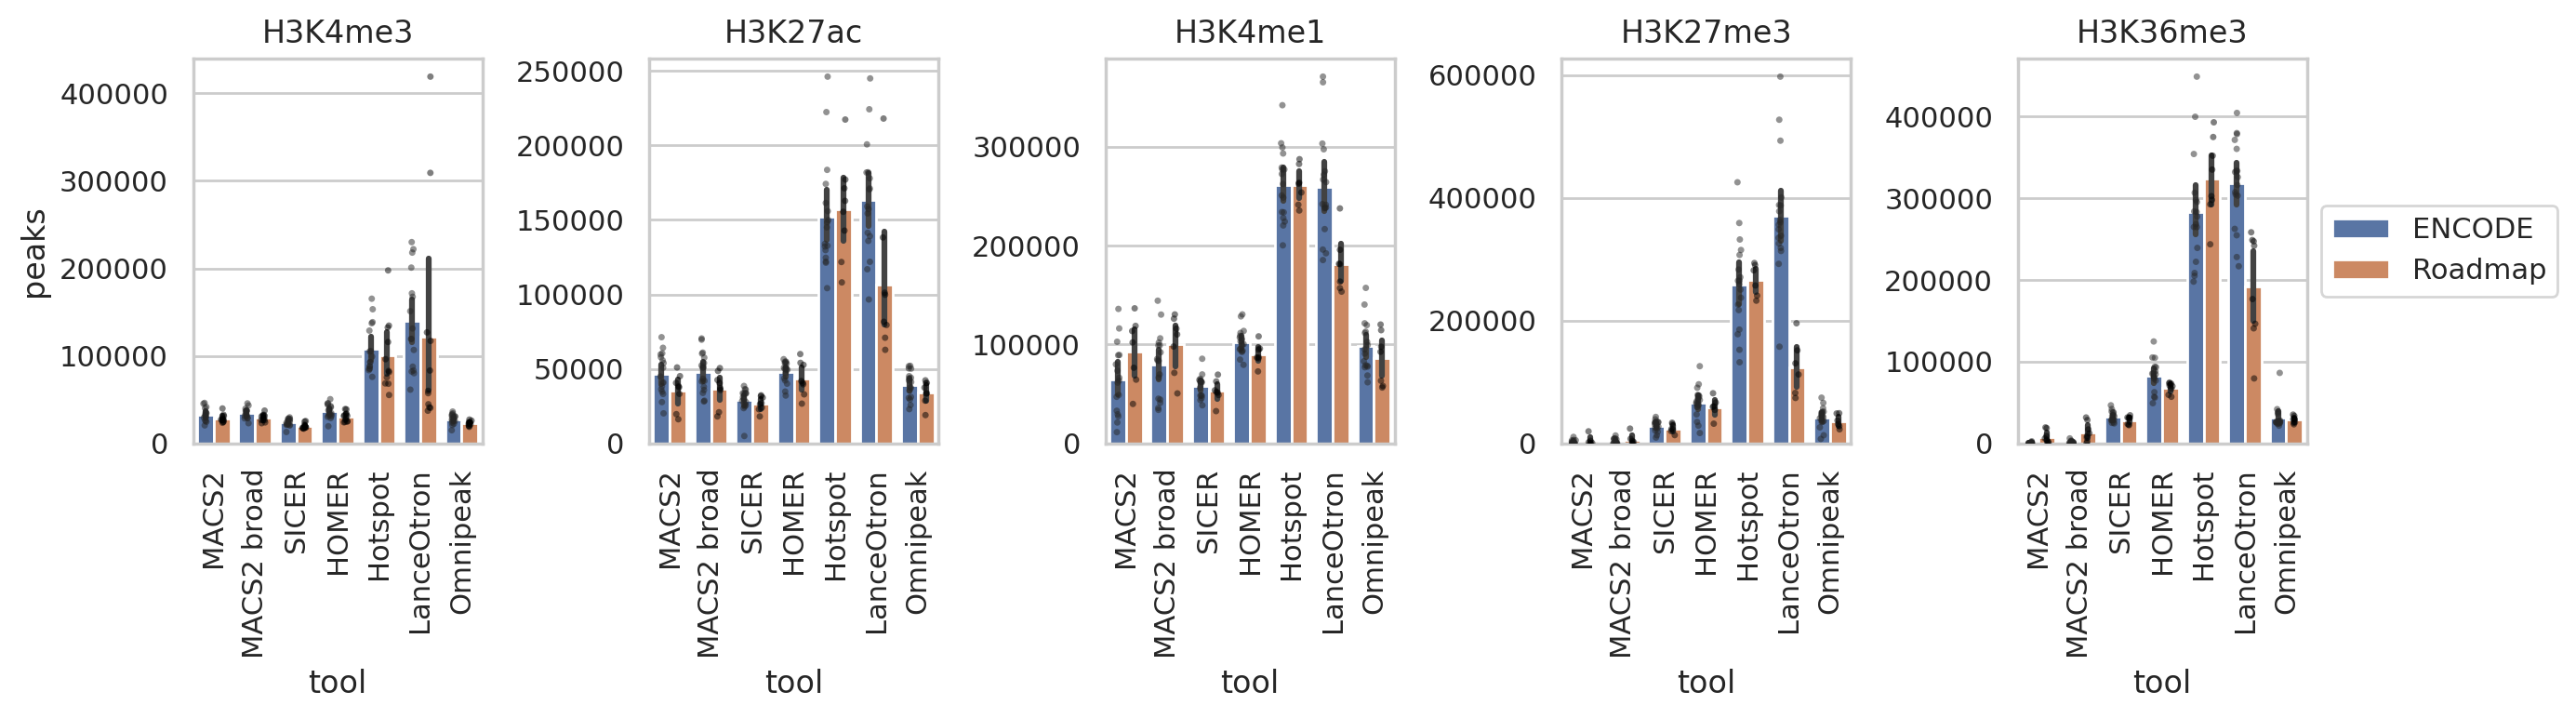

In [13]:
print('NO CONTROL')
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[(df_peaks['modification'] == m) & (df_peaks['control'] == False)],
                x='tool', y='peaks', hue='dataset',
                # capsize=.2, err_kws={'linewidth': 2}, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=TOOLS,
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.stripplot(data=df_peaks[(df_peaks['modification'] == m) & (df_peaks['control'] == False)],
                  x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=2.5, palette='dark:black', alpha=0.5, legend=False,
                  order=TOOLS,
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Lengths

In [14]:
def load_lens(df):
    print('Load lengths')
    ts = []
    for dataset, mod, cell, rep, file, tool in tqdm(list(zip(
            df['dataset'], df['modification'], df['cell'], df['replicate'], df['file'],
            df['tool']
    ))):
        lengths = bedl(file)
        t = pd.DataFrame(dict(length=lengths))
        t = t.sample(min(len(t), 10_000)).copy()
        t['dataset'] = dataset
        t['modification'] = mod
        t['cell'] = cell
        t['replicate'] = rep
        t['tool'] = tool
        t['footprint'] = sum(lengths)
        ts.append(t)
    df_lens = pd.concat(ts).reset_index(drop=True)
    del ts, t
    return df_lens

In [15]:
df_lens = load_lens(df_peaks[df_peaks['control'] == True])
df_lens_no_control = load_lens(df_peaks[df_peaks['control'] == False])

Load lengths


  0%|          | 0/875 [00:00<?, ?it/s]

Load lengths


  0%|          | 0/875 [00:00<?, ?it/s]

In [16]:
df_lens

,length,dataset,modification,cell,replicate,tool,footprint
0,162.0,ENCODE,H3K27me3,K562,rep2,MACS2,2972003
1,162.0,ENCODE,H3K27me3,K562,rep2,MACS2,2972003
2,314.0,ENCODE,H3K27me3,K562,rep2,MACS2,2972003
3,210.0,ENCODE,H3K27me3,K562,rep2,MACS2,2972003
4,227.0,ENCODE,H3K27me3,K562,rep2,MACS2,2972003
...,...,...,...,...,...,...,...
8422488,182.0,Roadmap,H3K4me3,CD4ABT,rep1,LanceOtron,58625013
8422489,1376.0,Roadmap,H3K4me3,CD4ABT,rep1,LanceOtron,58625013
8422490,455.0,Roadmap,H3K4me3,CD4ABT,rep1,LanceOtron,58625013
8422491,88.0,Roadmap,H3K4me3,CD4ABT,rep1,LanceOtron,58625013


In [17]:
from collections import Counter
def compute_avg_lens(df):
    ts = []
    for (ds, m, c, r, tool), dft in df[
        ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
    ].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']):
        dft.sort_values(by=['length'], inplace=True)
        ts.append(dft.iloc[int(len(dft) * 0.1): int(len(dft) * 0.9)])
    ts = pd.concat(ts).reset_index(drop=True)
    df_lens_avg = ts.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index()
    df_lens_avg['ds_c_r'] = df_lens_avg['dataset'] + ' ' + df_lens_avg['cell'] + ' ' + df_lens_avg['replicate']
    return df_lens_avg

In [18]:
df_lens_avg = compute_avg_lens(df_lens)
df_lens_no_control_avg = compute_avg_lens(df_lens_no_control)

with control
without control


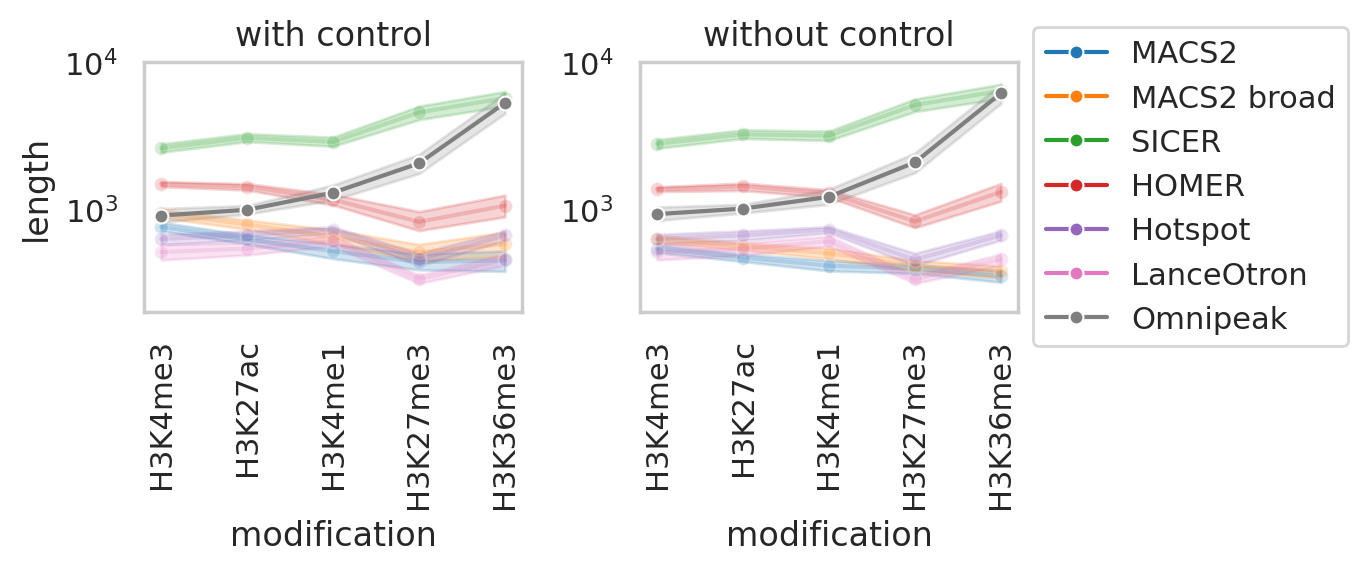

In [19]:
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, (df, name) in enumerate(zip([df_lens_avg, df_lens_no_control_avg],
                                   ['with control', 'without control'])):
    ax = axs[i]
    print(name)
    t = df.copy()
    t['mindex'] = 0
    for j, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        t.loc[t['modification'] == m, 'mindex'] = j
    t = t.sort_values(by=['mindex', 'tool', 'length'])
    sns.lineplot(data=t[t['tool'] != 'Omnipeak'],
             y='length', x='mindex', hue='tool', orient='x',
             alpha=0.2,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=False,
             ax=ax)
    sns.lineplot(data=t[t['tool'] == 'Omnipeak'],
             y='length', x='mindex', hue='tool', orient='x',
             alpha=1.0,
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             marker='o', markersize=5,
             legend=True,
             ax=ax)
    ax.set_xticks(range(5), minor=False)
    ax.set_xticklabels(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])
    ax.set_xlabel('modification')
    ax.set_ylabel('length')
    ax.set(yscale='log')
    ax.title.set_text(f'{name}')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(200, 1e4)
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    # Hide grid lines
    ax.grid(False)

plt.tight_layout()
plt.show()


# Compute ratio no control vs control

In [20]:
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        print(ds, m, c, r, t)
        if len(dft[dft['control'] == True]) != 1 or len(dft[dft['control'] == False]) != 1:
            continue
        with_control = dft[dft['control'] == True]['file'].values[0]
        without_control = dft[dft['control'] == False]['file'].values[0]
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        rows.append((ds, m, c, r, t, d(peaks_without_control, peaks_with_control)))
df_ratio = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool', 'ratio'])
df_ratio['ratio'] = ((df_ratio['ratio'] - 1) * 100).astype(int)
del rows
df_ratio.sample(3)

  0%|          | 0/875 [00:00<?, ?it/s]

ENCODE H3K27ac GM12878 rep1 HOMER
ENCODE H3K27ac GM12878 rep1 Hotspot
ENCODE H3K27ac GM12878 rep1 LanceOtron
ENCODE H3K27ac GM12878 rep1 MACS2
ENCODE H3K27ac GM12878 rep1 MACS2 broad
ENCODE H3K27ac GM12878 rep1 Omnipeak
ENCODE H3K27ac GM12878 rep1 SICER
ENCODE H3K27ac GM12878 rep2 HOMER
ENCODE H3K27ac GM12878 rep2 Hotspot
ENCODE H3K27ac GM12878 rep2 LanceOtron
ENCODE H3K27ac GM12878 rep2 MACS2
ENCODE H3K27ac GM12878 rep2 MACS2 broad
ENCODE H3K27ac GM12878 rep2 Omnipeak
ENCODE H3K27ac GM12878 rep2 SICER
ENCODE H3K27ac H1 rep1 HOMER
ENCODE H3K27ac H1 rep1 Hotspot
ENCODE H3K27ac H1 rep1 LanceOtron
ENCODE H3K27ac H1 rep1 MACS2
ENCODE H3K27ac H1 rep1 MACS2 broad
ENCODE H3K27ac H1 rep1 Omnipeak
ENCODE H3K27ac H1 rep1 SICER
ENCODE H3K27ac HMEC rep1 HOMER
ENCODE H3K27ac HMEC rep1 Hotspot
ENCODE H3K27ac HMEC rep1 LanceOtron
ENCODE H3K27ac HMEC rep1 MACS2
ENCODE H3K27ac HMEC rep1 MACS2 broad
ENCODE H3K27ac HMEC rep1 Omnipeak
ENCODE H3K27ac HMEC rep1 SICER
ENCODE H3K27ac HMEC rep2 HOMER
ENCODE H3

,dataset,modification,cell,replicate,tool,ratio
735,Roadmap,H3K36me3,PBMC,,HOMER,24
125,ENCODE,H3K27me3,GM12878,rep1,SICER,-27
422,ENCODE,H3K4me1,HepG2,rep1,LanceOtron,0


ENCODE


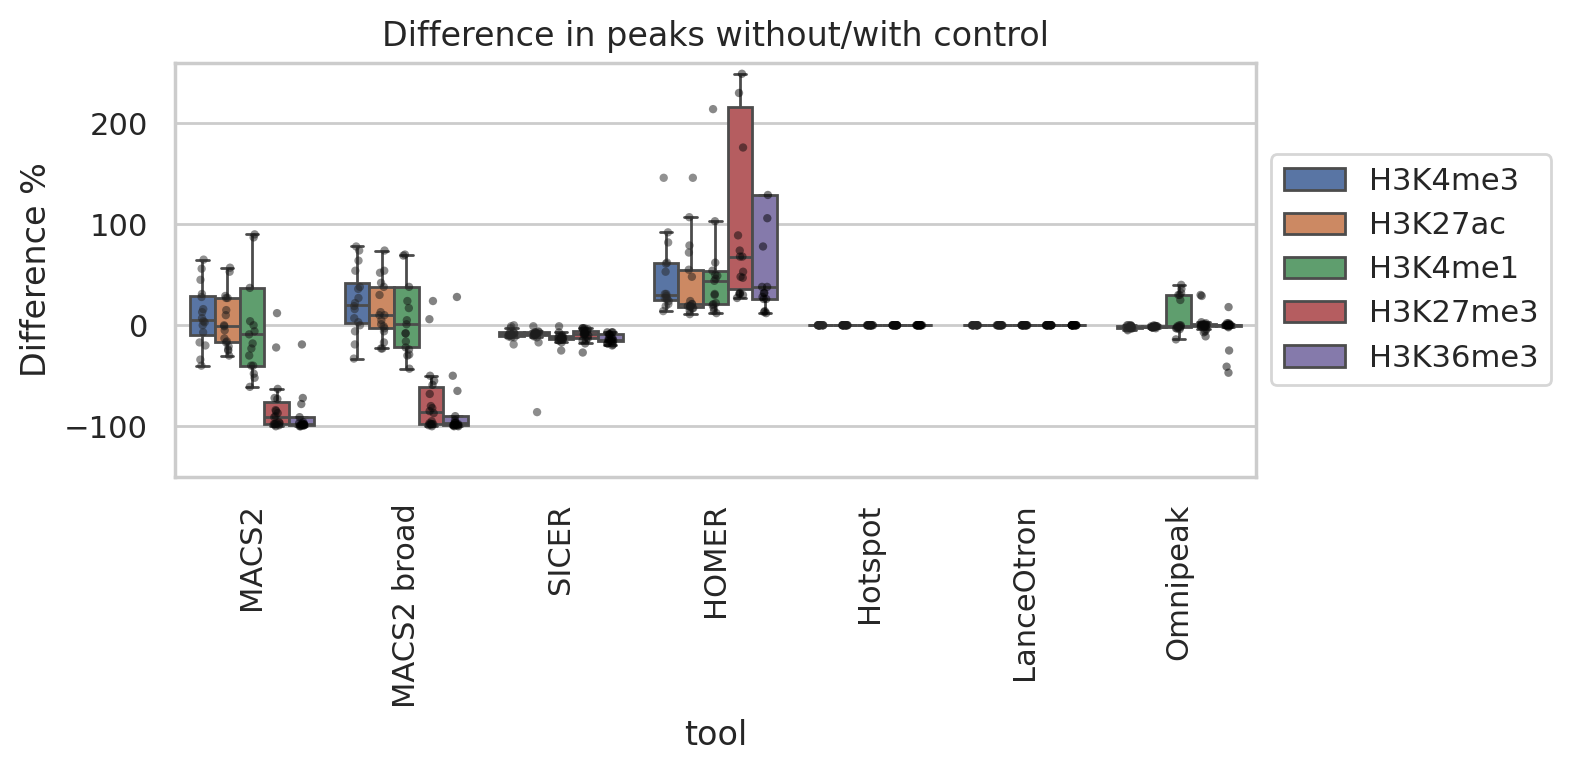

Roadmap


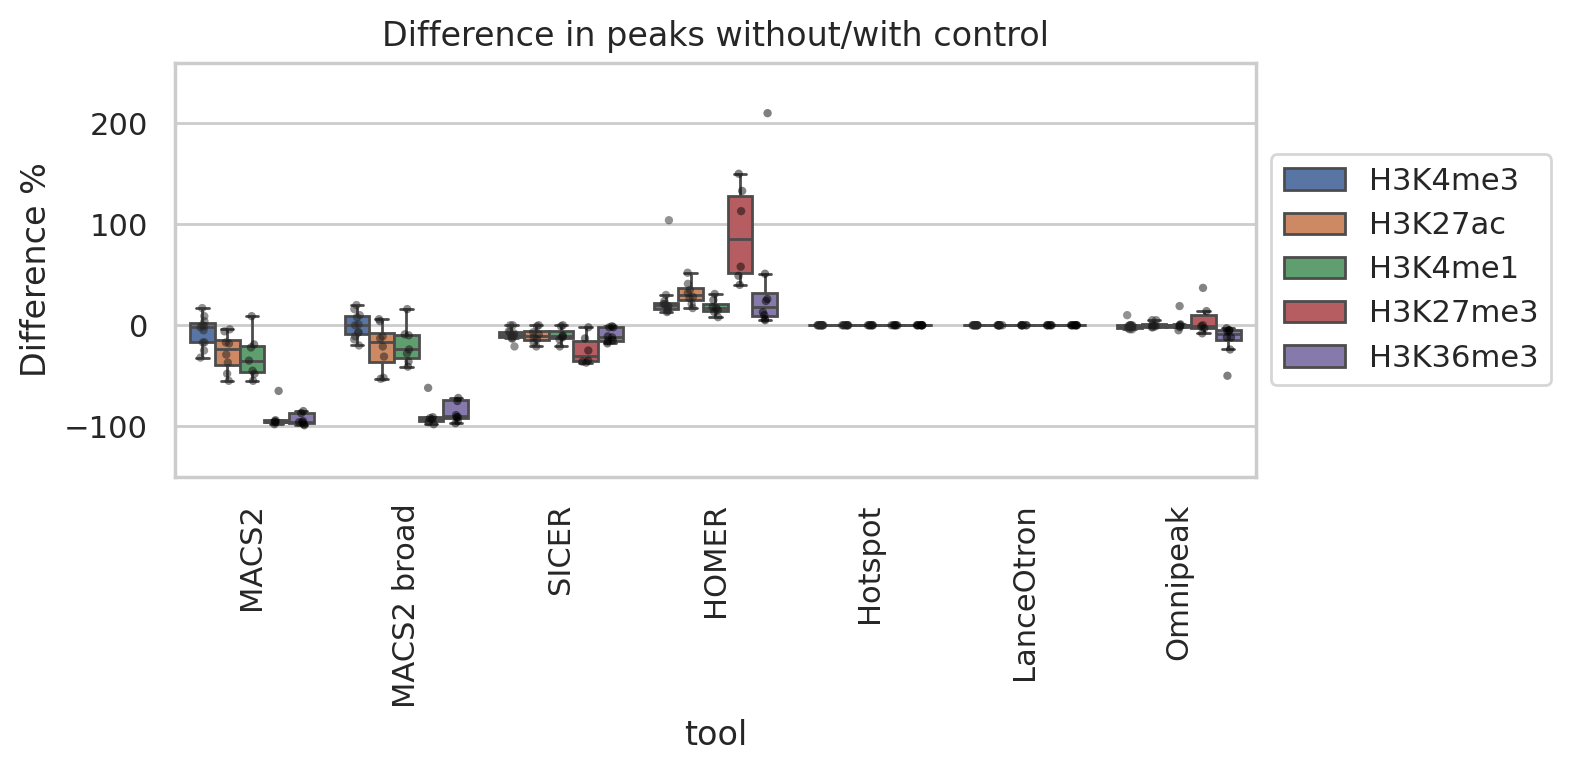

In [35]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(8, 4))
    ax = plt.axes()
    sns.boxplot(data=df_ratio[df_ratio['dataset'] == ds],
                x='tool', y='ratio', hue='modification',
                showfliers=False,
                order=TOOLS,
                hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                ax=ax)
    sns.stripplot(data=df_ratio[df_ratio['dataset'] == ds],
                  x='tool', y='ratio', hue='modification',
                  dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
                  hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  order=TOOLS, legend=False,
                  ax=ax)
    ax.set_ylabel('Difference %')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(-150, 260)
    ax.set_title('Difference in peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [22]:
df_ratio[(df_ratio['tool'] == 'MACS2') & 
         (df_ratio['modification'] == 'H3K4me3') & (df_ratio['ratio'] > 50)]

,dataset,modification,cell,replicate,tool,ratio
514,ENCODE,H3K4me3,HMEC,rep1,MACS2,56
542,ENCODE,H3K4me3,HepG2,rep2,MACS2,65


ENCODE + Roadmap


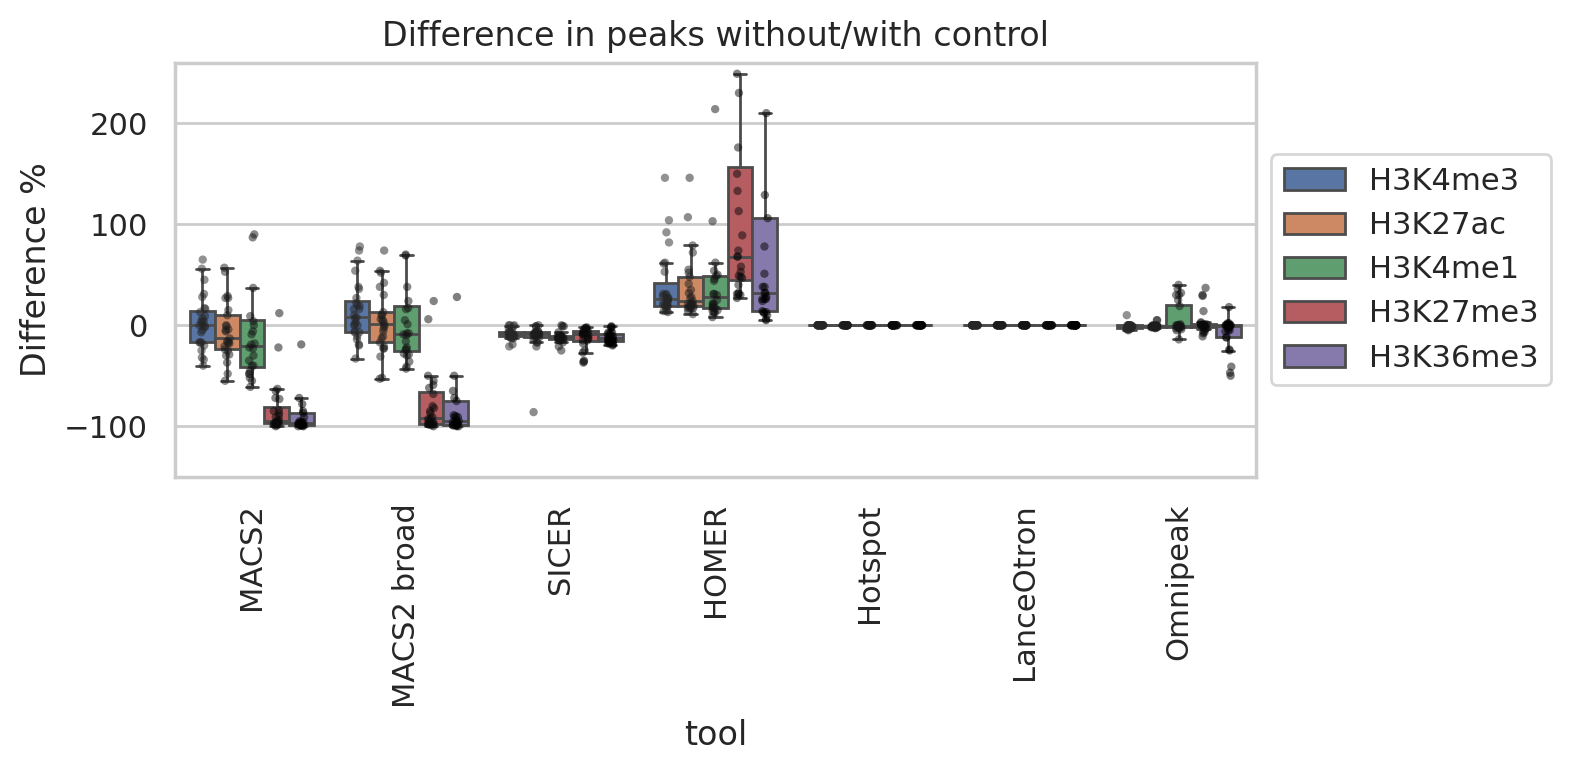

In [27]:
print('ENCODE + Roadmap')
plt.figure(figsize=(8, 4))
ax = plt.axes()
sns.boxplot(data=df_ratio,
            x='tool', y='ratio', hue='modification',
            showfliers=False,
            order=TOOLS,
            hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            ax=ax)
sns.stripplot(data=df_ratio,
              x='tool', y='ratio', hue='modification',
              dodge=True, size=3, alpha=0.5,
              hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              order=TOOLS, legend=False,
              palette='dark:black',
              ax=ax)
ax.set_ylabel('Difference %')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(-150, 260)
ax.set_title('Difference in peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [28]:
tf = tempfile.mktemp()
rows = []
for (ds, m, c, r, t), dft in tqdm(df_peaks.groupby(['dataset', 'modification', 'cell', 'replicate', 'tool'])):
    if len(dft) == 2:
        with_control = sorted_file(dft[dft['control'] == True]['file'].values[0])
        without_control = sorted_file(dft[dft['control'] == False]['file'].values[0])
        peaks_with_control = lines(with_control)
        peaks_without_control = lines(without_control)
        len_with_control = bedl(with_control).sum()
        len_without_control = bedl(without_control).sum()
        !bedtools intersect -a {with_control} -b {without_control} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        jaccard = d(overlap_len, len_with_control + len_without_control - overlap_len)
        rows.append((ds, m, c, r, t, peaks_with_control, peaks_without_control, len_with_control, len_without_control, 
                     d(len_with_control, peaks_with_control), d(len_without_control, peaks_without_control),
                     overlap_len, jaccard))
df_jaccard = pd.DataFrame(rows, columns=['dataset', 'modification', 'cell', 'replicate', 'tool',
                                         'peaks_with_control', 'peaks_without_control',
                                         'len_with_control', 'len_without_control', 
                                         'avg_len_with_control', 'avg_len_without_control',
                                         'overlap_len', 'jaccard'])
del rows
df_jaccard.sample(3)

  0%|          | 0/875 [00:00<?, ?it/s]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard
353,ENCODE,H3K36me3,NHLF,rep1,MACS2,3,160,979.0,52224,326.333333,326.400000,979,0.018746
51,ENCODE,H3K27ac,HepG2,rep1,LanceOtron,159026,159026,91802270.0,91802270,577.278370,577.278370,91802270,1.000000
164,ENCODE,H3K27me3,HSMM,rep1,MACS2,5126,56,1696548.0,24194,330.969177,432.035714,1349,0.000785


ENCODE


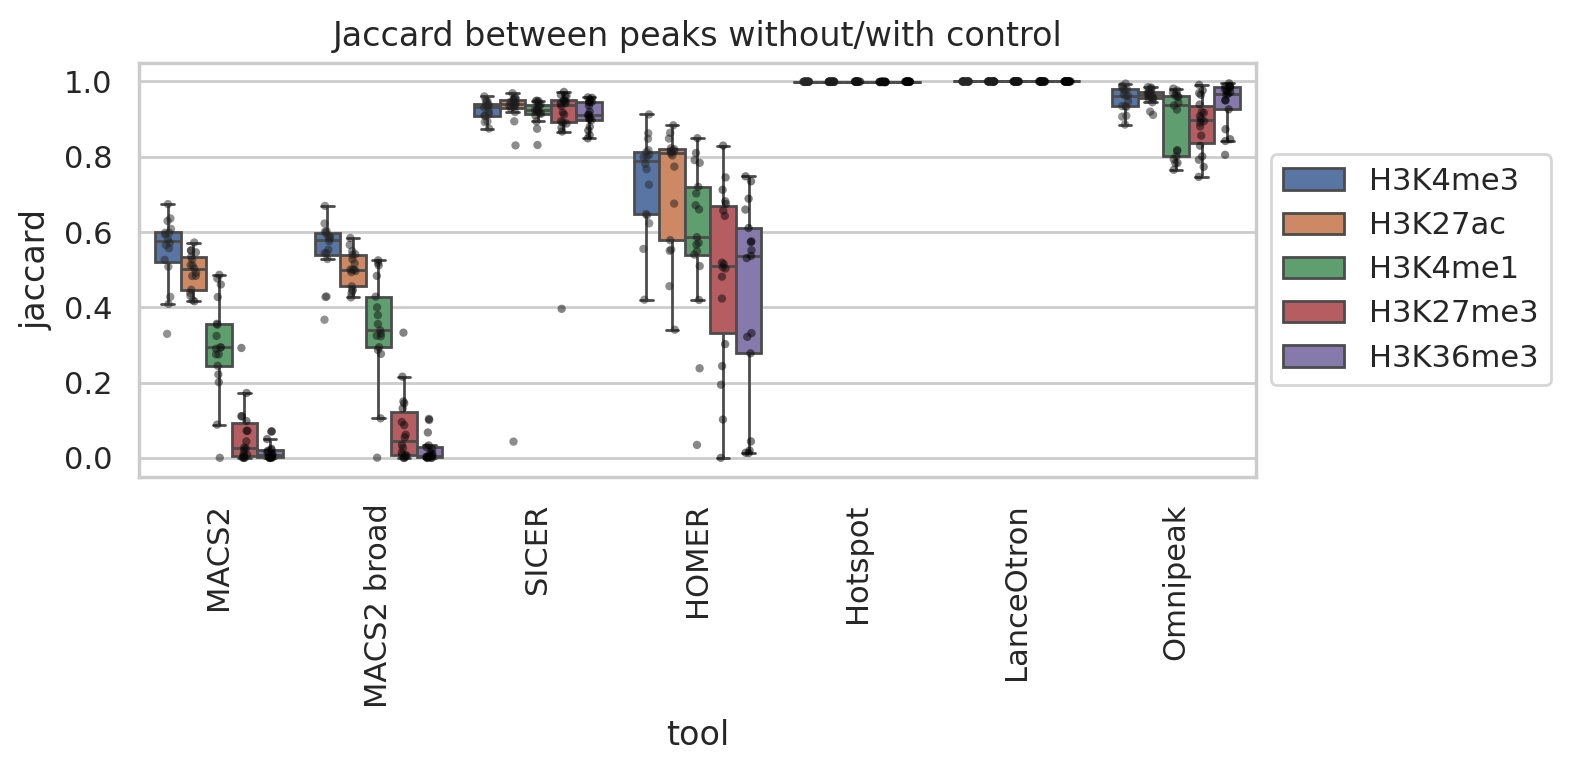

Roadmap


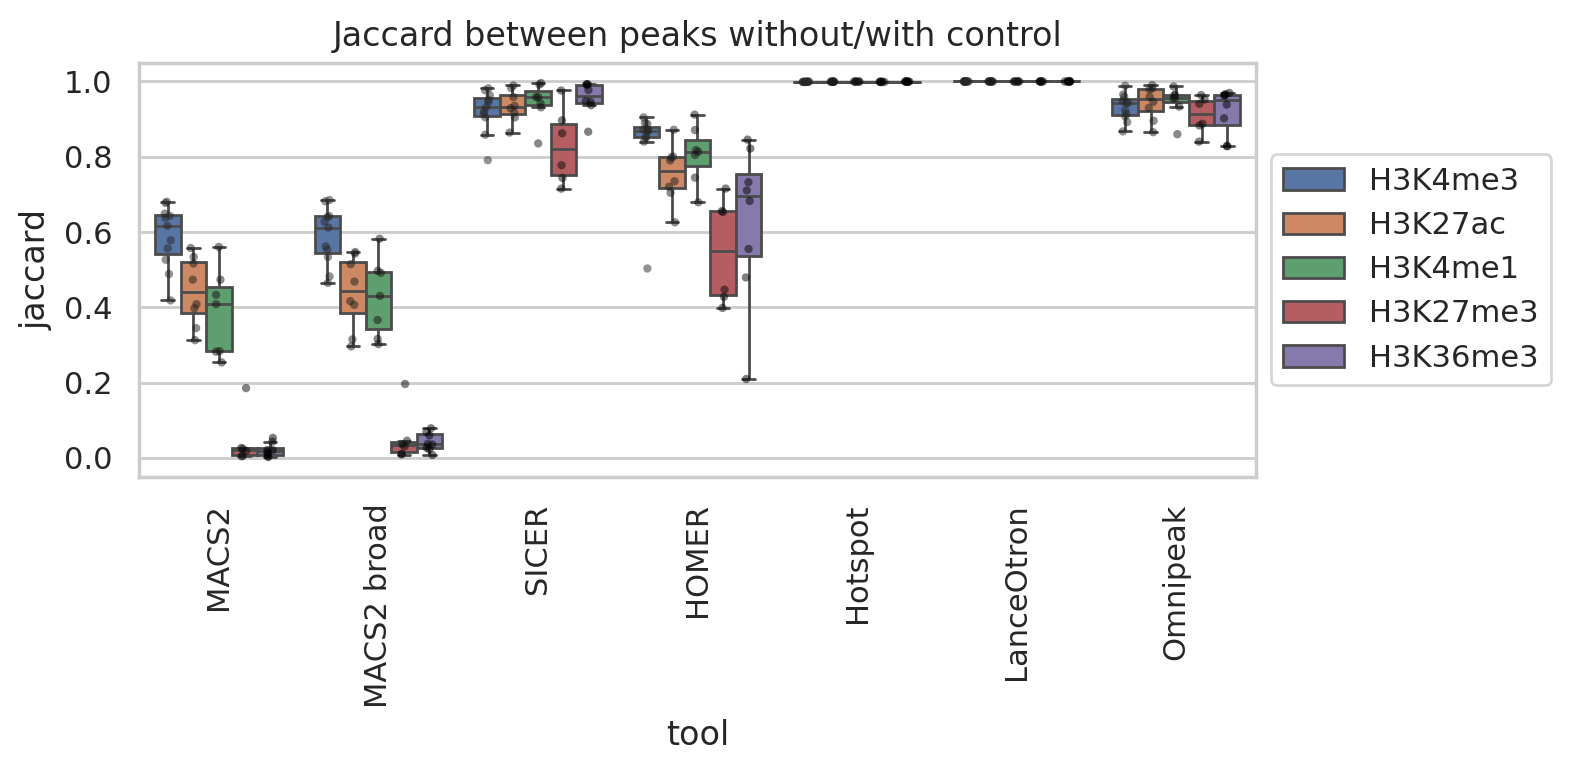

In [34]:
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    plt.figure(figsize=(8, 4))
    ax = plt.axes()
    sns.boxplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                x='tool', y='jaccard', hue='modification',
                showfliers=False,
                order=TOOLS,
                hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                ax=ax)
    sns.stripplot(data=df_jaccard[df_jaccard['dataset'] == ds],
                  x='tool', y='jaccard', hue='modification',
                  dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
                  hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
                  order=TOOLS, legend=False,
                  ax=ax)
    ax.set_ylabel('jaccard')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title('Jaccard between peaks without/with control')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [30]:
df_jaccard[(df_jaccard['tool'] == 'Omnipeak') &
           (df_jaccard['modification'] == 'H3K27me3') & 
           (df_jaccard['jaccard'] < 0.1)]

,dataset,modification,cell,replicate,tool,peaks_with_control,peaks_without_control,len_with_control,len_without_control,avg_len_with_control,avg_len_without_control,overlap_len,jaccard


ENCODE + Roadmap


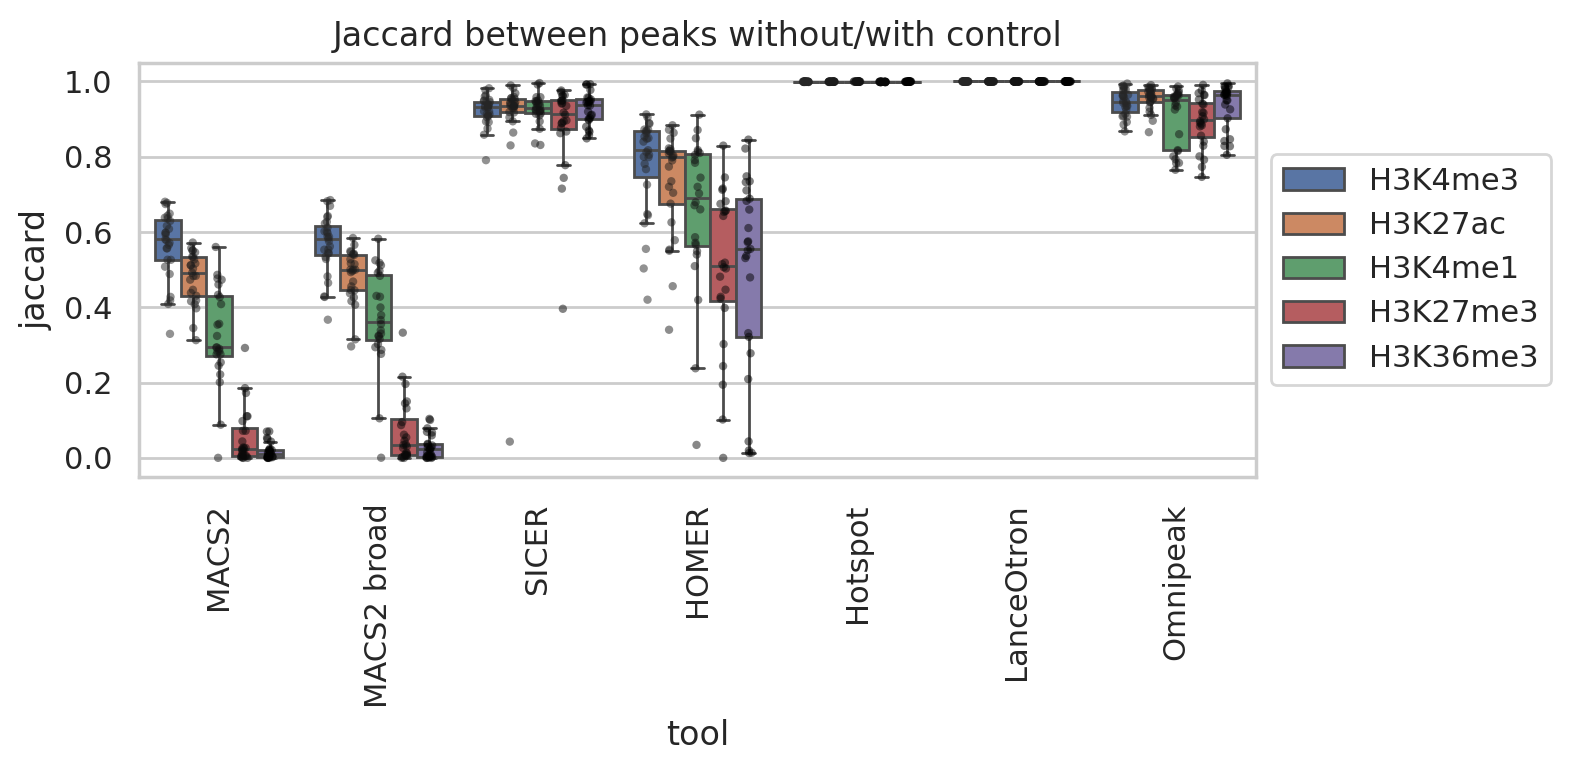

In [33]:
print('ENCODE + Roadmap')
plt.figure(figsize=(8, 4))
ax = plt.axes()
sns.boxplot(data=df_jaccard,
            x='tool', y='jaccard', hue='modification',
            showfliers=False,
            hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'],
            # palette = TOOLS_PALETTE,
            ax=ax)
sns.stripplot(data=df_jaccard,
              x='tool', y='jaccard', hue='modification',
              dodge=True, size=3, color="black", alpha=0.5, palette='dark:black',
              hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
              order=['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'LanceOtron', 'Omnipeak'], legend=False,
              ax=ax)
ax.set_ylabel('jaccard')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(-0.05, 1.05)
ax.set_title('Jaccard between peaks without/with control')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# END